# Overview
- このノートブックでは、datetime.time などで生成されるオブジェクトについて紹介します。 
- また、時系列データをプロットする際に、datetime.time などのオブジェクトがいいよという提案でもあります

# Import everything I need :)

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

# Preparation

## load data

In [2]:
filename = librosa.util.example_audio_file()
_data, sr = librosa.load(filename)
data = _data
for _ in range(9):
    data = np.hstack([data, _data])
x_sec    = np.arange(0, len(data))/sr
x_min    = x_sec / 60

# 横軸単位問題について
- 時系列のデータをプロットする際、横軸の単位をどうするのか迷うところ。

---
**index**

Text(0.5, 0, 'index')

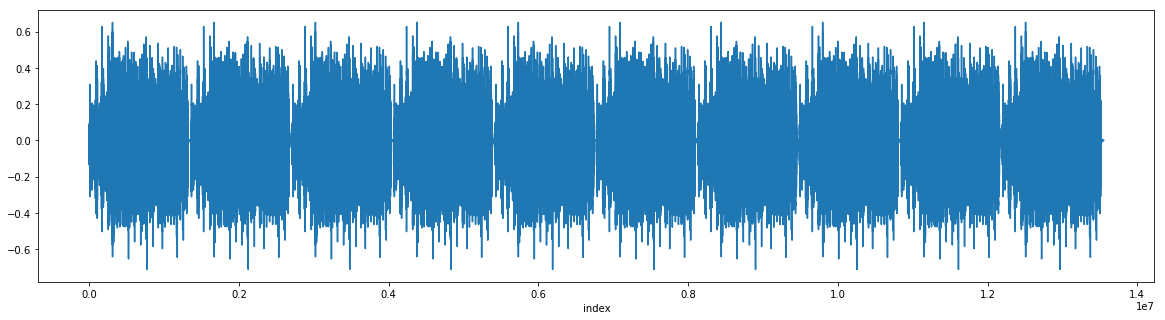

In [3]:
plt.figure(figsize=(20, 5))
plt.plot(data)
plt.xlabel('index')

---> よくあるパターンが、とりあえず `index`で書いて後で必要になれば、わかりやすい単位(秒とか)に直すパターン。やめた方が良いと思います。逆にやること増える気がします。  
---> 上のグラフは、周期的なパターンが見えますが、その周期が何秒程度か読み取ることができません。

---
**秒**

Text(0.5, 0, 'sec')

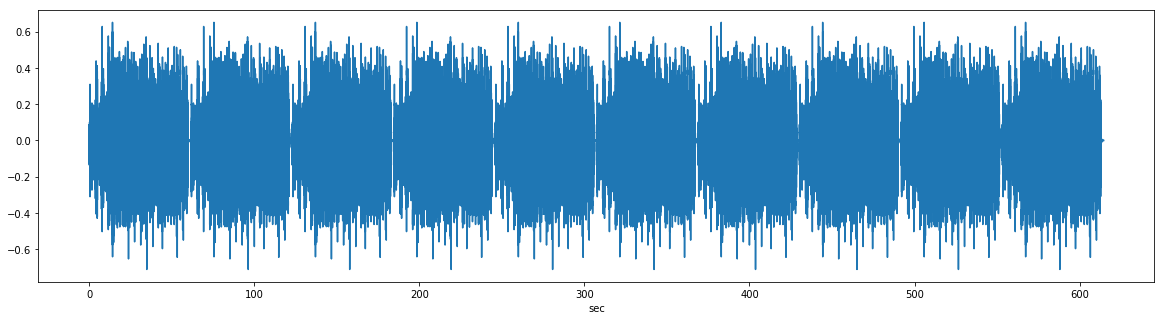

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(x_sec, data)
plt.xlabel('sec')

---> `index`よりは、大分マシですね。  
---> 上のグラフの大まかな繰り返しの周期は、60秒程度でしょうか。  
---> 問題といえば、秒数が多くなって4230秒などとなると感覚的な捉え方が難しくなるとかでしょうか。  
---> あとは、例えば、247秒あたりに特徴的なピークがあり、他のツール(audacityなど)で対象部分の音を聞いてみたい。といった場合、秒から分に頭の中で変換して...といった事をよくやります。  
---> やっぱり、横軸は、分単位がいいのか？

---
**分**

Text(0.5, 0, 'minute')

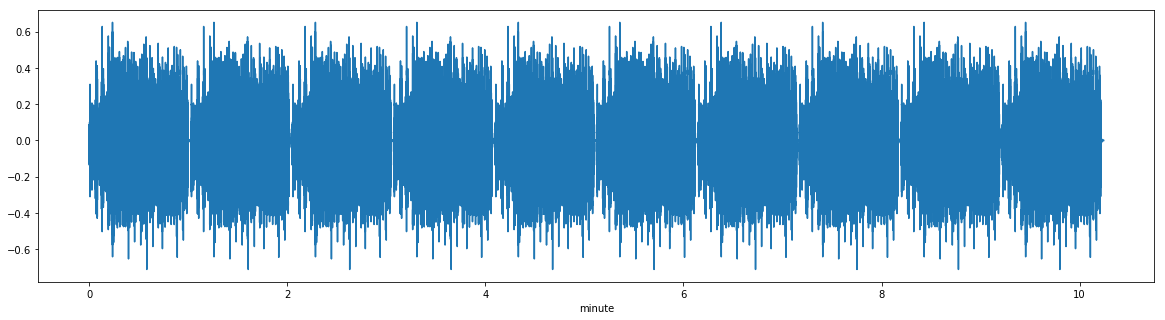

In [6]:
plt.figure(figsize=(20, 5))
plt.plot(x_sec/60, data)
plt.xlabel('minute')

---> これで、わかりやすくなりましたね。  
---> 問題解決でしょうか。  
---> いやしかし、まだ問題はでてきます。

# スライスめんどくさい問題
- グラフの、5.9分から8.1分の部分を抜き出して拡大したいなーと思うことありますよね？  
- 分を秒になおして...インデックスに直して... めんどくさい！みたいなことあいますよね？  
- 上のグラフの5.9分から、8.1分を抜き出してみましょう。

Text(0.5, 0, 'minute')

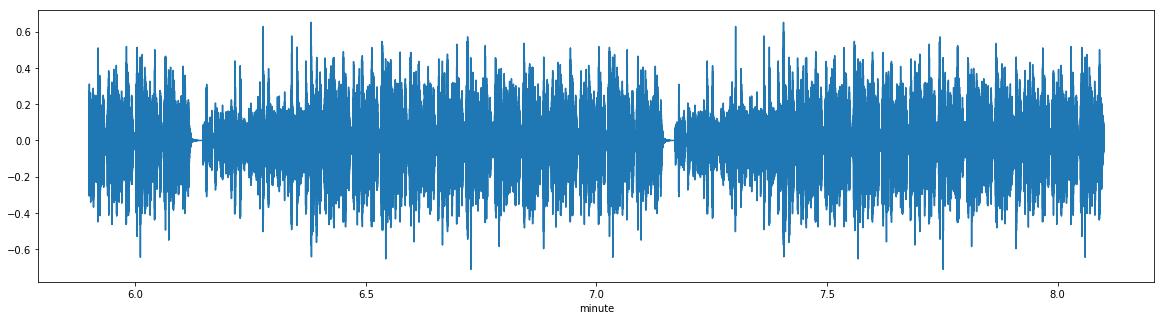

In [14]:
start_min = 5.9
end_min   = 8.1

# minute --> second ---> index
start_idx = int(start_min*60*sr)
end_idx   = int(end_min*60*sr)

plt.figure(figsize=(20, 5))
plt.plot(x_min[start_idx:end_idx], data[start_idx:end_idx])
plt.xlabel('minute')

---> できました。  
---> めんどくさいですけど、まあよくやる手順です。  
---> 拡大したおかげで構造が見えてきました。だいたい、6.1分から、7.2分ぐらいが単位構造(?)になっているようですね。  
6.1分から、7.2分の間隔は何秒程度なのでしょうか？  
めんどくさいのは、7.2分は、7分と2秒ではないということです。  
0.1 分は、6秒なので、、、とかいうめんどくさい計算をしないといけないです。  
例えば、0.38 分が何秒かすぐ言えますか？  
言えない私はこれが原因で、ストレスを抱えたことが多々有ります。

# 提案手法
datetime のオブジェクトを使用する方法を提案します。  
`datetime.time()` の関数を使うと、 `hour:minute:second` という形で時間を扱えます。数値ではなく、オブジェクトです。

In [8]:
# example
print(datetime.time(hour=2, minute=3, second=4))
print(datetime.time(second=5, microsecond=30))

02:03:04
00:00:05.000030


---> 上記のようなオブジェクトになります。  
---> 秒から、 `datetime.time` オブジェクトに変換する関数(`sec2time`)を作成しました。  
---> これを利用すれば、簡単に`datetime.time`オブジェクをに変換できます。

---

In [3]:
def sec2time(sec, mode='microsecond'):
    '''
    return : hour:minute:second:nanosecond
           : hour:minute:second:microsecond
    using plotly   : mode='nanosecond'
    using matplolib: mode='microsecond'
    '''
    
    sec = float(sec)
    decimal = '{:.9f}'.format(sec)
    decimal = str(decimal).split('.')[1]
    
    hour        = int(sec//3600)
    minute      = int((sec - 3600*hour)//60)
    second      = int(sec - 3600*hour - 60*minute)
    
    if mode=='nanosecond':
        nanosecond = decimal[:9]
        nanosecond = int(nanosecond)
        time = pd.Timestamp(year=2000, month=1, day=1,
                          hour=hour, minute=minute, second=second, nanosecond=nanosecond)
    elif mode=='microsecond':
        microsecond = decimal[:6]
        microsecond = int(microsecond)
        time = datetime.datetime(year=2000, month=1, day=1,
                          hour=hour, minute=minute, second=second, microsecond=microsecond)
        
    return time.time()

In [9]:
# example
print(sec2time(3661))
print(sec2time(3662.666))

01:01:01
01:01:02.666000


## 実践

以前定義した変数から`datetime.time` オブジェクトに変換します。  
`x_sec`に、秒単位のオブジェクトが入っているので、それをつかいましょう。

In [10]:
x_time = [sec2time(sec) for sec in x_sec]
x_time = np.array(x_time)

---> 変換しました。

どう変わったのか見てみましょう。 

In [15]:
for i in range(3, 100000 ,10000):
    print(f'{x_sec[i]} 秒  ----> {x_time[i]}')

0.00013605442176870748 秒  ----> 00:00:00.000136
0.45365079365079364 秒  ----> 00:00:00.453650
0.9071655328798186 秒  ----> 00:00:00.907165
1.3606802721088436 秒  ----> 00:00:01.360680
1.8141950113378684 秒  ----> 00:00:01.814195
2.2677097505668935 秒  ----> 00:00:02.267709
2.7212244897959184 秒  ----> 00:00:02.721224
3.174739229024943 秒  ----> 00:00:03.174739
3.628253968253968 秒  ----> 00:00:03.628253
4.081768707482993 秒  ----> 00:00:04.081768


---> こんな感じです

plot して比較してみます。

Text(0.5, 0, 'time')

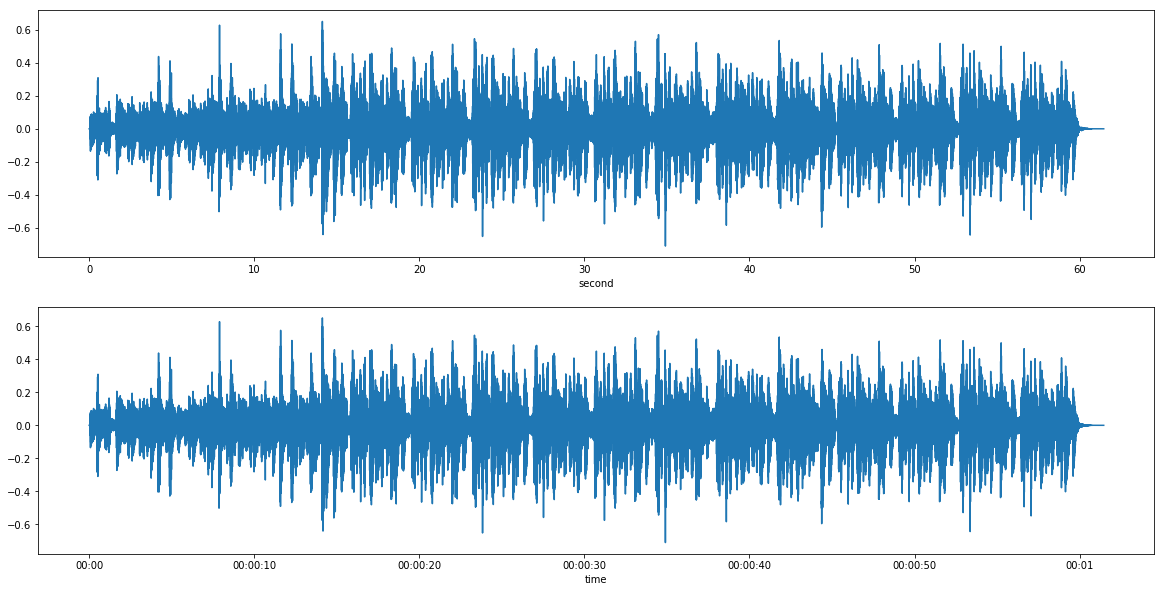

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(20, int(5*2)))
axs = axs.ravel()

axs[0].plot(x_sec, data)
axs[0].set_xlabel('second')
axs[1].plot(x_time, data)
axs[1].set_xlabel('time')

---> 分も秒表示されていますね。とてもわかりやすいです。  
---> さらに、スライスもとても直感的に行なえます。次の例で見てみましょう。

---

00:03:20 秒以下を抜き出して見ましょう。  
datetime.time オブジェクトを使えば、インデックスに変換して...という手順が必要なくなります！

[datetime.time(0, 0) datetime.time(0, 0, 0, 45) datetime.time(0, 0, 0, 90)
 ... datetime.time(0, 10, 14, 588526) datetime.time(0, 10, 14, 588571)
 datetime.time(0, 10, 14, 588616)]
[ True  True  True ... False False False]


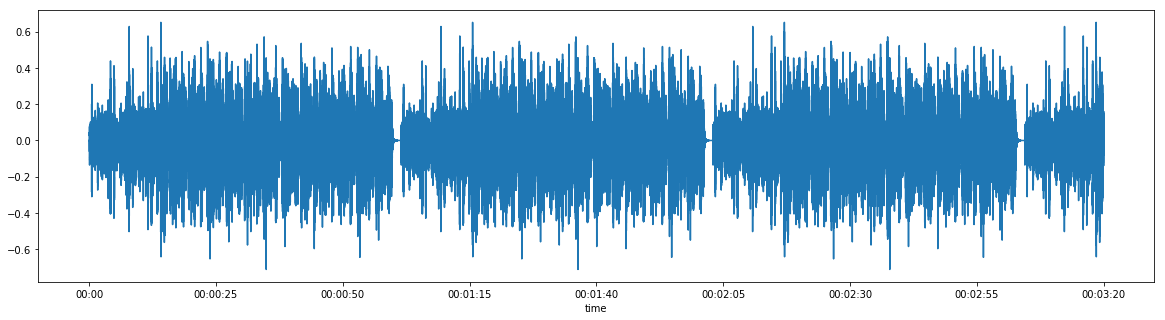

In [21]:
et = datetime.time(minute=3, second=20)   # et: end_time, 3分20秒
idx = x_time < et
plt.figure(figsize=(20, 5))
plt.plot(x_time[idx], data[idx])

print(x_time)
print(idx)

---> 非常に簡単で直感的です。  
---> 続いて、00:01:50 から 00:01:51 までを表示してしてみましょう。

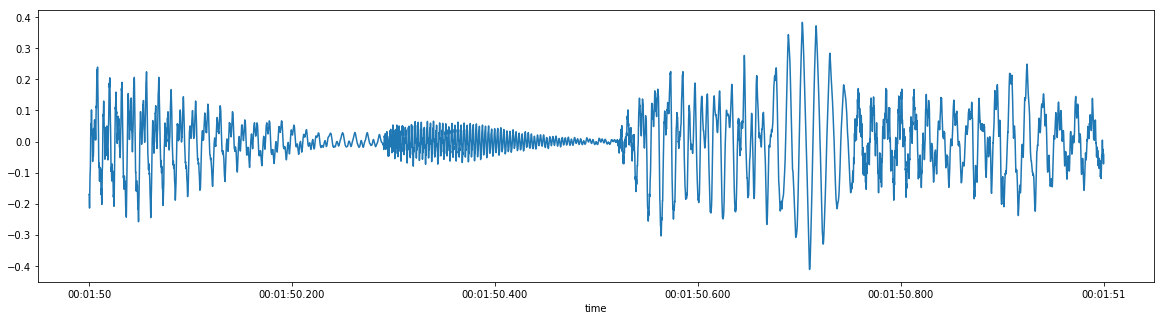

In [19]:
st = datetime.time(minute=1, second=50)  # st: start_time
et = datetime.time(minute=1, second=51)  # et: end_time
idx = (st<x_time) & (x_time<et)
plt.figure(figsize=(20, 5))
plt.plot(x_time[idx], data[idx])

---> 小さい領域でもとてもいい感じに表示してくれます。  
---> では、秒と分でも表示してみましょう。

Text(0.5, 0, 'minute')

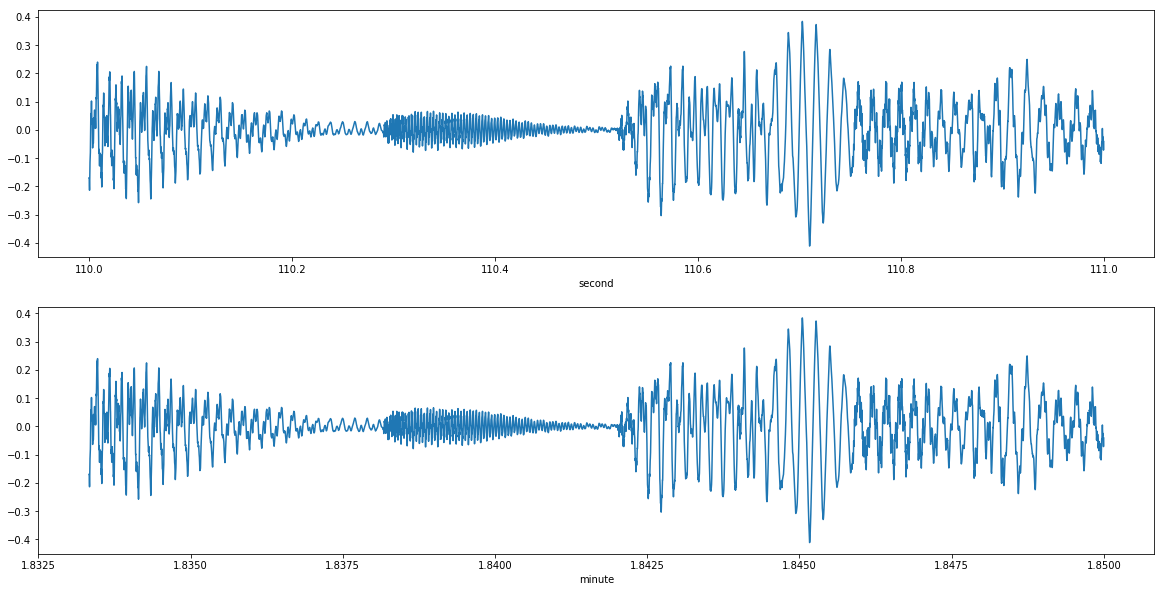

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs = axs.ravel()

axs[0].plot(x_sec[idx], data[idx])
axs[0].set_xlabel('second')
axs[1].plot(x_min[idx], data[idx])
axs[1].set_xlabel('minute')

---> datetime.time オブジェクトを使った場合とどっちがいいでしょうか。  
---> 答えは明らかだと思います。

# Summary

In [22]:
# load example data
filename = librosa.util.example_audio_file()
data, sr = librosa.load(filename)

In [24]:
# datetime.time オブジェクトの生成
x_sec  = np.arange(0, len(data))/sr
x_time = [sec2time(sec) for sec in x_sec]
x_time = np.array(x_time)

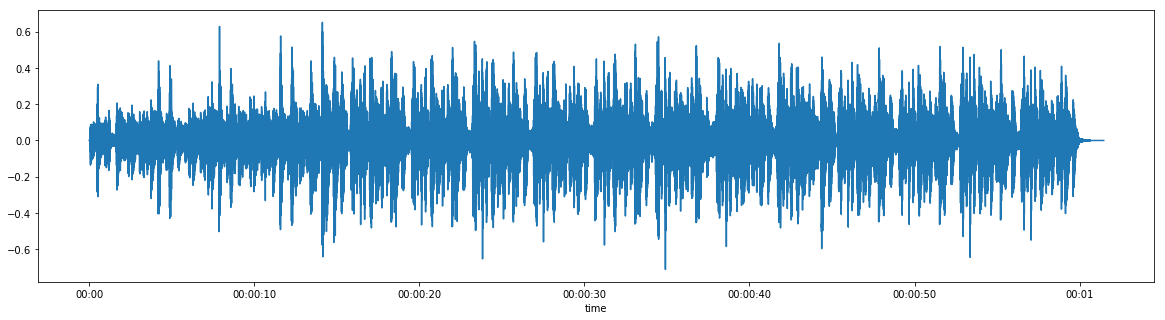

In [25]:
# plot
plt.figure(figsize=(20, 5))
plt.plot(x_time, data)

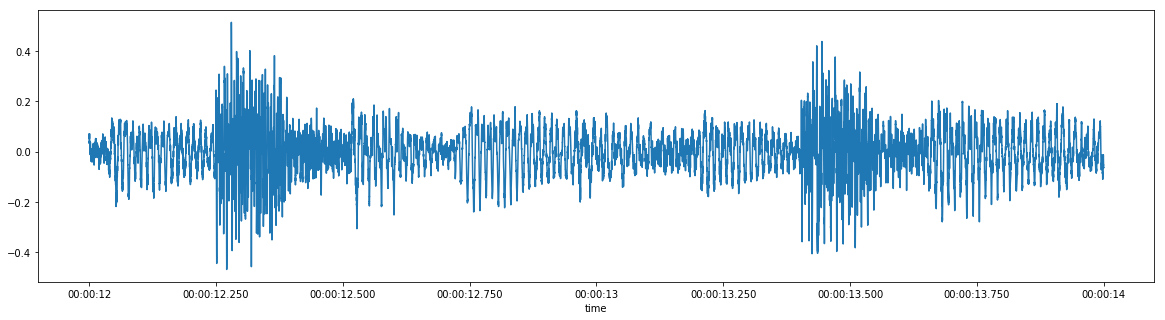

In [30]:
# 12秒から14秒を表示
st = datetime.time(second=12)
et = datetime.time(second=14)
idx = (st<x_time) & (x_time<et)

plt.figure(figsize=(20, 5))
plt.plot(x_time[idx], data[idx])